In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [3]:
sales = pd.read_excel('./Relatas_ML_Assignment/sales-pipeline.xlsx')
sales_conf = pd.read_excel('./Relatas_ML_Assignment/sales-pipeline.xlsx')

In [4]:
sentiment = pd.read_excel('sentiment.xlsx')
sentiment_conf = pd.read_excel('sentiment.xlsx')

In [5]:
sentiment['InteractionDate'] = pd.to_datetime(sentiment['InteractionDate'])
sentiment_conf['InteractionDate'] = pd.to_datetime(sentiment_conf['InteractionDate'])

grouped = sentiment.set_index(['InteractionDate'])
goruped_conf = sentiment_conf.set_index(['InteractionDate'])

grouped.loc[grouped.sentiment == 'POSITIVE', 'positive'] = 1
grouped['positive'] = grouped['positive'].fillna(0)
grouped.loc[grouped.sentiment == 'NEGATIVE', 'negative'] = 1
grouped['negative'] = grouped['negative'].fillna(0)

goruped_conf.loc[(goruped_conf.sentiment == 'POSITIVE') &  (goruped_conf.conf>=0.95) , 'positive'] = 1
goruped_conf.loc[(goruped_conf.sentiment == 'NEGATIVE') &  (goruped_conf.conf>=0.95) , 'negative'] = 1
goruped_conf['positive'] = goruped_conf['positive'].fillna(0)
goruped_conf['negative'] = goruped_conf['negative'].fillna(0)

In [6]:
for index,rows in sales.iterrows():
    a = rows['ContactEmailID']
    sales.loc[index,'postive']  = grouped.loc[rows['Created Date']:rows['Close Date']].query('positive == 1 and toEmailId==@a')['positive'].sum()
    sales.loc[index,'negative']  = grouped.loc[rows['Created Date']:rows['Close Date']].query('negative == 1 and toEmailId==@a')['negative'].sum()

In [7]:
for index,rows in sales_conf.iterrows():
    a = rows['ContactEmailID']
    sales_conf.loc[index,'postive']  = goruped_conf.loc[rows['Created Date']:rows['Close Date']].query('positive == 1 and toEmailId==@a')['positive'].sum()
    sales_conf.loc[index,'negative']  = goruped_conf.loc[rows['Created Date']:rows['Close Date']].query('negative == 1 and toEmailId==@a')['negative'].sum()
sales_conf['sum']  = sales_conf['postive'] + sales_conf['negative']
sales['sum'] = sales['postive'] + sales['negative']
sales_conf['diff']  = sales_conf['postive'] - sales_conf['negative']
sales['diff'] = sales['postive'] - sales['negative']
sales_conf.rename(columns={"Close Date":"Close_Date"} ,inplace=True)

In [40]:
data  = sales_conf.query('Deal_Stage == "Won"').set_index('Close_Date')[['Close_Value','diff']].resample('M').sum()

In [182]:
data = data.loc[:'2019-07-01']

In [183]:
train_data  = data.loc[:'20190101']
test_data = data.loc['20190101':]

In [184]:
train_data_diff = train_data.diff().dropna()

<AxesSubplot:xlabel='Close_Date'>

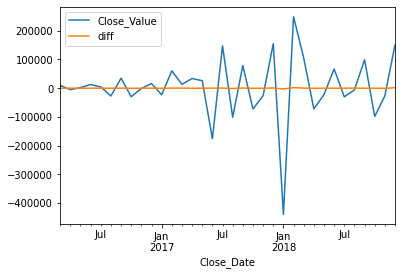

In [185]:
train_data_diff.plot()

In [186]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [187]:
for name, column in train_data_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close_Value" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.4755
 No. Lags Chosen       = 1
 Critical value 1%     = -3.654
 Critical value 5%     = -2.957
 Critical value 10%    = -2.618
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0384
 No. Lags Chosen       = 10
 Critical value 1%     = -3.753
 Critical value 5%     = -2.998
 Critical value 10%    = -2.639
 => P-Value = 0.0315. Rejecting Null Hypothesis.
 => Series is Stationary.




In [157]:
#train_data_diff = train_data_diff.diff().dropna()

In [188]:
for name, column in train_data_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Close_Value" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.4755
 No. Lags Chosen       = 1
 Critical value 1%     = -3.654
 Critical value 5%     = -2.957
 Critical value 10%    = -2.618
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "diff" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.0384
 No. Lags Chosen       = 10
 Critical value 1%     = -3.753
 Critical value 5%     = -2.998
 Critical value 10%    = -2.639
 => P-Value = 0.0315. Rejecting Null Hypothesis.
 => Series is Stationary.




<AxesSubplot:xlabel='Close_Date'>

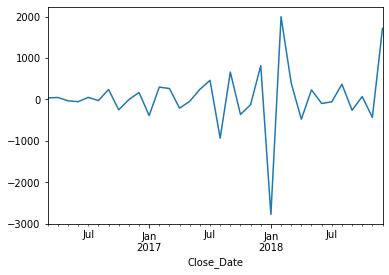

In [189]:
train_data_diff['diff'].plot()

In [190]:
model = VAR(train_data_diff)
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,36.18,36.28,5.146e+15,36.20
1,35.69,35.99,3.167e+15,35.76
2,35.51,36.01,2.689e+15,35.63
3,35.77,36.47,3.590e+15,35.93
4,35.99,36.88,4.725e+15,36.20
5,36.33,37.42,7.288e+15,36.58
6,36.41,37.70,9.222e+15,36.71
7,36.33,37.82,1.100e+16,36.68
8,36.10,37.78,1.316e+16,36.50
9,35.10,36.98,1.031e+16,35.54


In [191]:
fitted = model.fit(12)

In [192]:
def adjust(val, length= 6): return str(val).ljust(length)
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(fitted.resid)

for col, val in zip(data.columns, out):
    print(adjust(col), ':', round(val, 2))

Close_Value : 2.57
diff   : 2.24


In [193]:
lag_order = fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = train_data_diff.values[-lag_order:]
forecast_input

12


array([[-4.39182e+05, -2.77800e+03],
       [ 2.48671e+05,  1.99600e+03],
       [ 1.05667e+05,  3.95000e+02],
       [-7.20060e+04, -4.79000e+02],
       [-2.20160e+04,  2.30000e+02],
       [ 6.68390e+04, -9.80000e+01],
       [-3.01270e+04, -5.90000e+01],
       [-6.07300e+03,  3.66000e+02],
       [ 9.89560e+04, -2.62000e+02],
       [-9.81810e+04,  6.90000e+01],
       [-2.65190e+04, -4.33000e+02],
       [ 1.50599e+05,  1.71700e+03]])

In [194]:
fc = fitted.forecast(y=forecast_input, steps=6)
df_forecast = pd.DataFrame(fc, index=data.index[-6:], columns=data.columns + '_1d')
df_forecast

,Close_Value_1d,diff_1d
Close_Date,,
2019-01-31,-8.014217e+05,-5533.380067
2019-02-28,3.899649e+05,3451.121101
2019-03-31,9.491169e+05,2664.043773
2019-04-30,-1.213913e+06,-3947.696695
2019-05-31,2.674704e+06,3854.838445
2019-06-30,-3.879282e+06,-4436.104104


In [195]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [196]:
df_results = invert_transformation(train_data, df_forecast, second_diff=False)        
df_results.loc[:, ['Close_Value_forecast', 'diff_forecast']]

,Close_Value_forecast,diff_forecast
Close_Date,,
2019-01-31,-6.957467e+05,-4079.380067
2019-02-28,-3.057818e+05,-628.258967
2019-03-31,6.433351e+05,2035.784807
2019-04-30,-5.705778e+05,-1911.911889
2019-05-31,2.104126e+06,1942.926557
2019-06-30,-1.775156e+06,-2493.177547


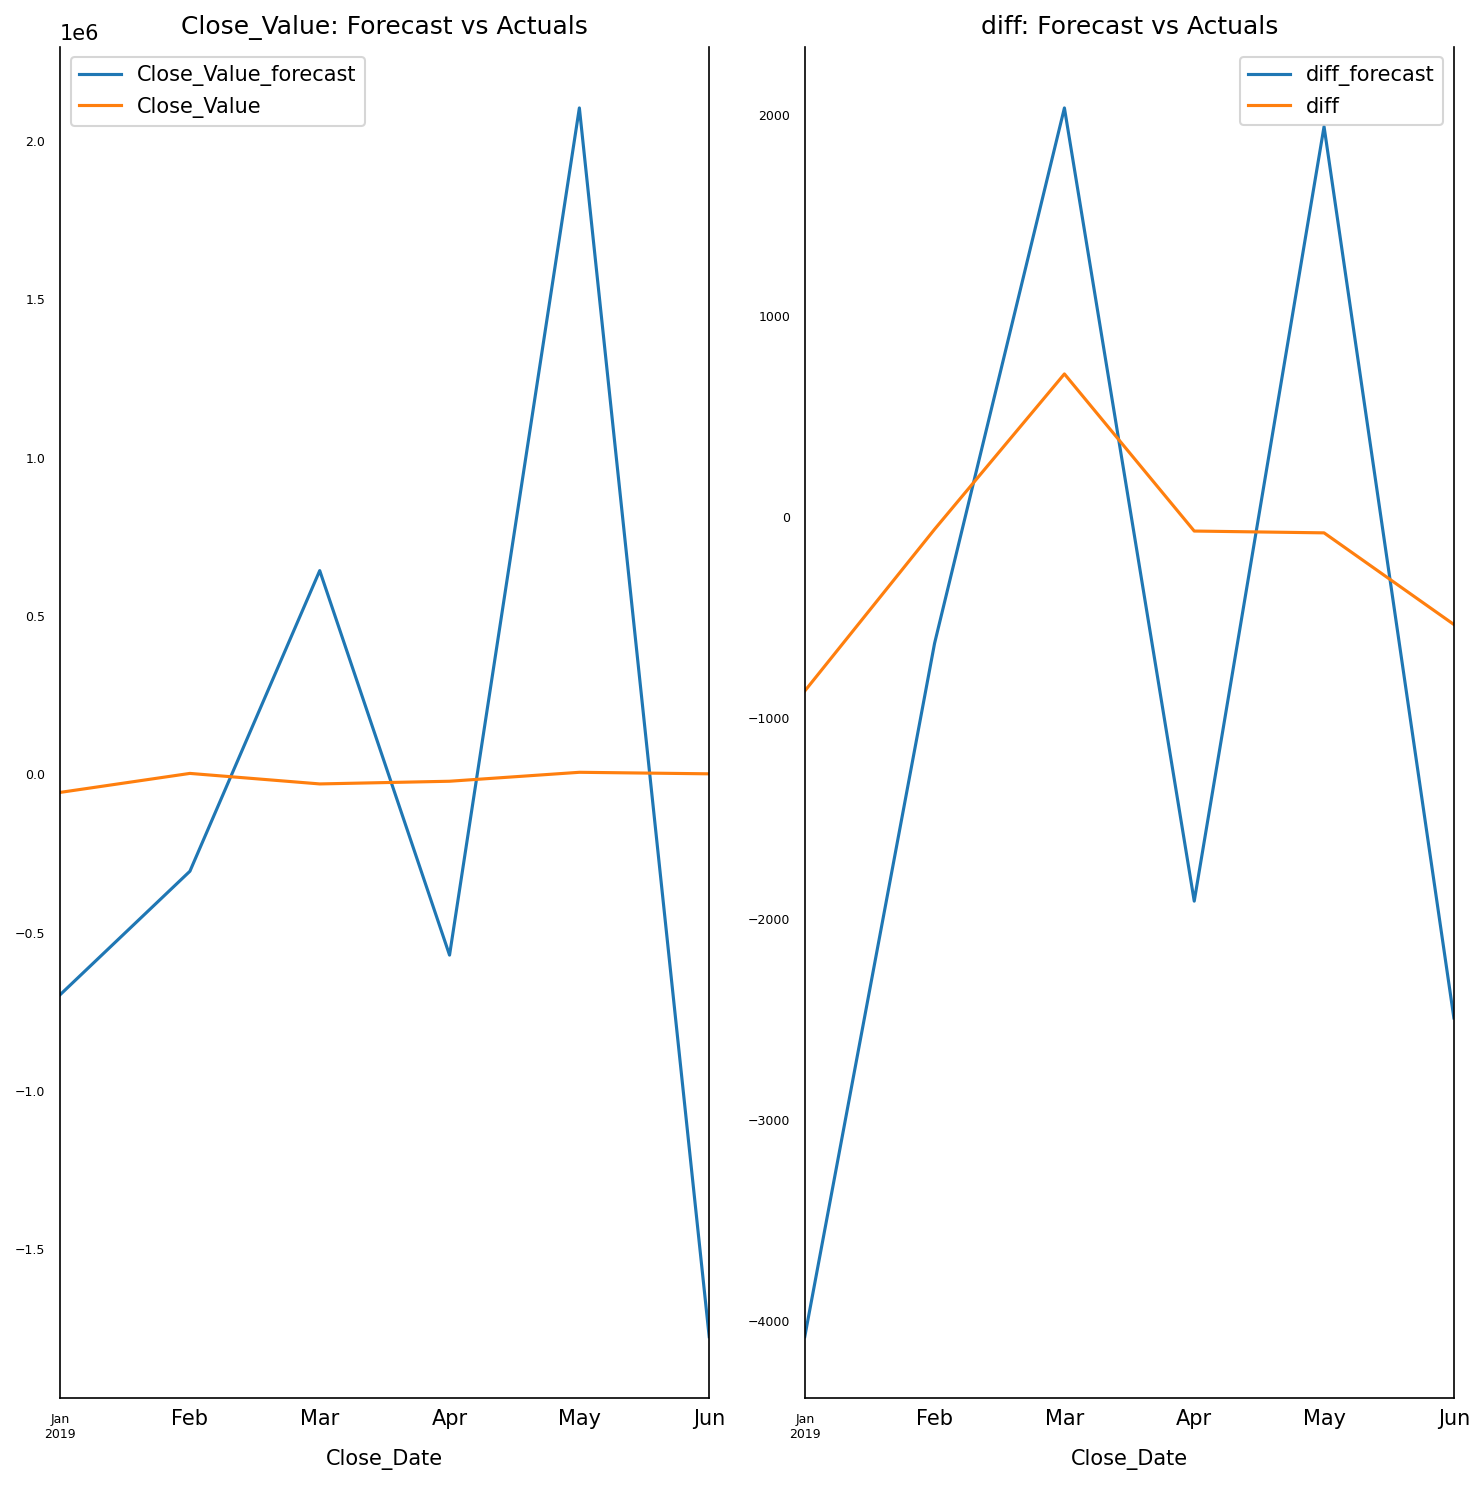

In [197]:
fig, axes = plt.subplots(nrows=int(len(data.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test_data[col][-6:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [198]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Close_Value')
accuracy_prod = forecast_accuracy(df_results['Close_Value_forecast'].values, test_data['Close_Value'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: diff')
accuracy_prod = forecast_accuracy(df_results['diff_forecast'].values, test_data['diff'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


Forecast Accuracy of: Close_Value
mape   :  245.6296
me     :  -83776.2452
mae    :  1007426.631
mpe    :  -127.8996
rmse   :  1212120.4488
corr   :  0.1976
minmax :  177.2804

Forecast Accuracy of: diff
mape   :  11.7394
me     :  -705.8362
mae    :  1821.0733
mpe    :  3.2081
rmse   :  1988.1015
corr   :  0.8456
minmax :  -6.882
